[*********************100%***********************]  1 of 1 completed


== 交易明細 ==
        entry       exit          ep          xp    手續費       net_pnl  \
0  2023-06-07 2023-06-08  146.451979  148.452820  21.98  27302.207493   
1  2023-06-09 2023-06-12  148.601049  148.119354  21.98  -6593.541776   
2  2023-06-13 2023-06-14  147.961864  149.657043  21.98  23129.014064   
3  2023-06-15 2023-06-16  150.110986  152.130325  21.98  27472.349594   
4  2023-06-20 2023-06-21  152.158132  151.806122  21.98  -4813.856298   
..        ...        ...         ...         ...    ...           ...   
79 2025-04-21 2025-04-22  152.871620  154.289810  21.98  22512.685749   
80 2025-04-30 2025-05-01  154.729936  151.071991  21.98 -57979.896836   
81 2025-05-02 2025-05-05  152.392361  151.600128  21.98 -12465.551519   
82 2025-05-07 2025-05-08  153.282402  152.245651  21.98 -16127.318730   
83 2025-05-09 2025-05-12  152.480383  150.759003  21.98 -26721.242771   

         roi  
0   0.013651  
1  -0.003252  
2   0.011446  
3   0.013442  
4  -0.002324  
..       ...  
79  0.0

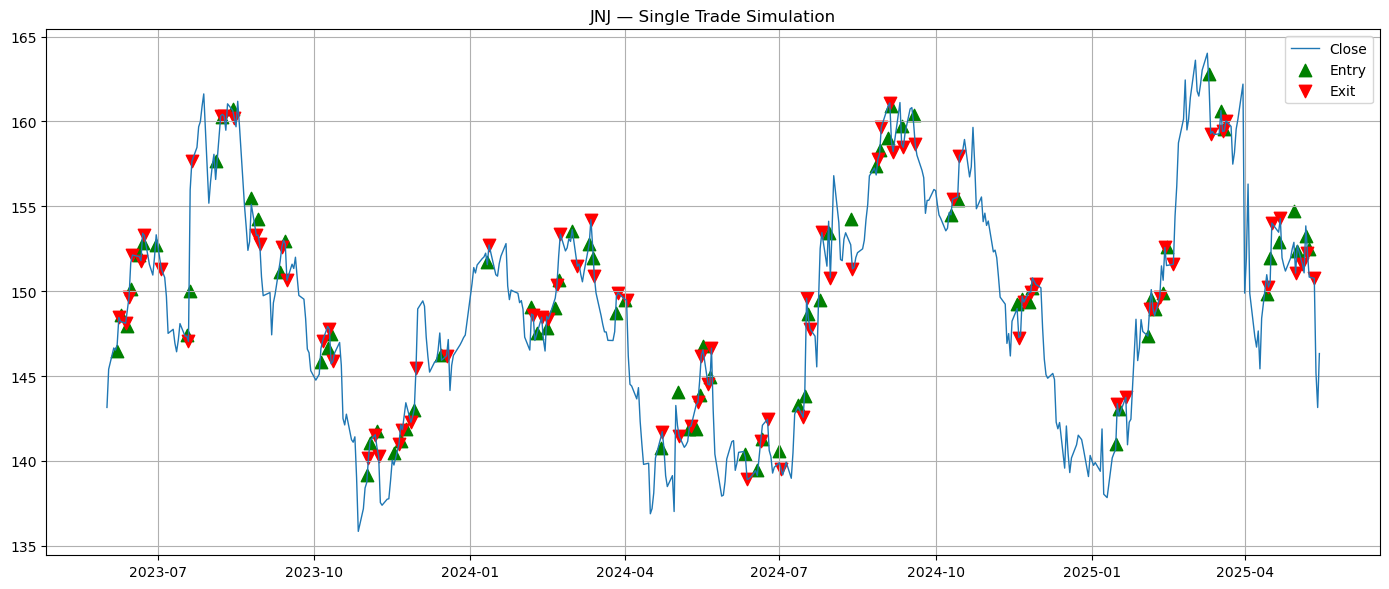

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ticker = "JNJ" 
df = yf.download(
    ticker,
    start="2023-06-01",  
    end="2025-05-16",    
    interval="1d",
    group_by="column"
)

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df = df.dropna(subset=['Open','High','Low','Close'])

df['upper_shadow'] = df['High'] - np.maximum(df['Open'], df['Close'])
df['lower_shadow'] = np.minimum(df['Open'], df['Close']) - df['Low']
df['body']         = (df['Close'] - df['Open']).abs()
df['raw_entry'] = False
df['entry_price'] = np.nan
for i in range(4, len(df)):
    K = df.iloc[i-4:i+1] 
    mask_up = K['upper_shadow'] >= 0.2 * K['body'] 
    if not mask_up.any(): continue
    first_up = mask_up[mask_up].index[0]
    high_ref = df.at[first_up, 'High']
    sub = K.loc[K.index > first_up] 
    mask_low = (sub['Close'] < sub['Open']) & (sub['lower_shadow'] >= 0.3 * sub['body'])
    if not mask_low.to_numpy().any(): continue
    k3 = K.iloc[-1]  
    if k3['High'] <= high_ref: continue 
    df.at[k3.name, 'raw_entry'] = True
    if k3['Low'] <= high_ref <= k3['High']:
        df.at[k3.name, 'entry_price'] = high_ref
    elif k3['Open'] > high_ref:
        df.at[k3.name, 'entry_price'] = k3['Open']
    else:
        df.at[k3.name, 'raw_entry'] = False

df['raw_exit'] = False
take_profit = 1.10  
stop_loss   = 0.967
ret_pct     = 0.25  
for entry_date, row in df[df['raw_entry']].iterrows():
    entry_price = row['entry_price']
    tp_price = entry_price * take_profit
    sl_price = entry_price * stop_loss
    dd_th = tp_price - (tp_price - entry_price) * ret_pct
    future = df.loc[entry_date:].iloc[1:] 
    tp = future[future['High'] >= tp_price]
    sl = future[future['Low']  <= sl_price]
    dd = future[future['Low']  <= dd_th]
    tp_date = tp.index.min() if not tp.empty else pd.NaT 
    sl_date = sl.index.min() if not sl.empty else pd.NaT
    dd_date = dd.index.min() if not dd.empty else pd.NaT
    dates = [d for d in (tp_date, sl_date, dd_date) if not pd.isna(d)]
    if not dates:
      continue
    exit_day = min(dates) 
    df.at[exit_day, 'raw_exit'] = True

df['entry'] = False 
df['exit']  = False
in_position = False 
for date in df.index:  
    if not in_position and df.at[date, 'raw_entry']: 
        df.at[date, 'entry'] = True
        in_position = True
    elif in_position and df.at[date, 'raw_exit']: 
        df.at[date, 'exit'] = True
        in_position = False
        
trades = []
capital = 2000000          
entry_fee = 10.99          
exit_fee  = 10.99          
entries = list(df[df['entry']].index)
exits   = list(df[df['exit'] ].index)
for e in entries:
    ex = next((x for x in exits if x > e), None)
    if ex is None:
        continue
    ep = df.at[e, 'entry_price']   
    xp = df.at[ex, 'Close']        
    shares = capital / ep 
    gross_profit = shares * (xp - ep) 
    commission   = entry_fee + exit_fee 
    profit       = gross_profit - commission
    roi          = profit / capital   
    capital += profit
    trades.append({
        'entry':      e,
        'exit':       ex,
        'ep':         ep,
        'xp':         xp,
        'gross_pnl':  gross_profit,
        '手續費': commission,
        'net_pnl':    profit,
        'roi':        roi
    })

trades_df = pd.DataFrame(trades)
total_profit = trades_df['net_pnl'].sum()
total_roi    = total_profit / 2000000  
print("== 交易明細 ==")
print(trades_df[['entry','exit','ep','xp','手續費','net_pnl','roi']])


initial_capital = 2000000
final_capital   = capital  
if entries and exits:
    start_date = entries[0]
    end_date   = exits[-1]
    years = (end_date - start_date).days / 365.25  
    cagr = (final_capital / initial_capital) ** (1/years) - 1  
    factors = [(df.at[exit,'Close'] / df.at[entry,'entry_price']) for entry, exit in zip(entries, exits)]
    twrr = np.prod(factors) ** (1/years) - 1 
    print("Final Capital:", capital,"  Total Net Profit:", total_profit)
    print("Total ROI:", f"{total_roi:.2%}")
    print(f"CAGR: {cagr:.2%}")
    print(f"Time-Weighted Return: {twrr:.2%}")
else:
    print("無法計算CAGR")

plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close', lw=1)
plt.scatter(df[df['entry']].index, df[df['entry']]['entry_price'],
            marker='^', color='green', s=80, label='Entry')
plt.scatter(df[df['exit']].index,  df[df['exit']]['Close'],
            marker='v', color='red', s=80, label='Exit')
plt.title(f"{ticker} — Single Trade Simulation")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

已將交易明細儲存至：BAC.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>